In [1]:
import pandas as pd
import os

# File path
file_path = os.path.join("./", "superstore.csv")

# Load the dataset with encoding fix
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Fix data types
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

categorical_cols = ['Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode', 'City', 'State', 'Country']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Quick preview
print(df.dtypes)
df.head()


Row ID                         int64
Order ID                      object
Order Date            datetime64[ns]
Ship Date             datetime64[ns]
Ship Mode                   category
Customer ID                   object
Customer Name                 object
Segment                     category
Country                     category
City                        category
State                       category
Postal Code                    int64
Region                      category
Product ID                    object
Category                    category
Sub-Category                category
Product Name                  object
Sales                        float64
Quantity                       int64
Discount                     float64
Profit                       float64
Shipping Delay                 int64
Discount Binned               object
Discounted Revenue           float64
Profit Margin                float64
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Delay,Discount Binned,Discounted Revenue,Profit Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,3,No Discount,261.960000,0.1600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,3,No Discount,731.940000,0.3000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,4,No Discount,14.620000,0.4700
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,7,41-100%,526.667625,-0.4000
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,7,11-20%,17.894400,0.1125


In [2]:
# Check for missing values
print(df.isnull().sum())

# Remove duplicate rows if any
df = df.drop_duplicates()


Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
Country               0
City                  0
State                 0
Postal Code           0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Delay        0
Discount Binned       0
Discounted Revenue    0
Profit Margin         0
dtype: int64


In [3]:
# Select the essential columns for our analysis
cols_to_keep = ['Order Date', 'Sales', 'Quantity', 'Discount', 'Profit']
df_reduced = df[cols_to_keep].copy()

In [4]:
import numpy as np
# Add a transaction count column (each row is one transaction)
df_reduced['Transaction Count'] = 1

# Aggregate data by Order Date with a weighted average for discount (weighted by Sales)
daily_aggregated = df_reduced.groupby('Order Date').apply(lambda x: pd.Series({
    'Sales': x['Sales'].sum(),
    'Quantity': x['Quantity'].sum(),
    'Discount': np.average(x['Discount'], weights=x['Sales']),
    'Profit': x['Profit'].sum(),
    'Transaction Count': x['Transaction Count'].sum()
})).reset_index()

C:\Users\rites\AppData\Local\Temp\ipykernel_28204\1035071026.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_aggregated = df_reduced.groupby('Order Date').apply(lambda x: pd.Series({


In [5]:
# Sort the aggregated data by Order Date in ascending order
daily_aggregated = daily_aggregated.sort_values('Order Date')

In [6]:
print(daily_aggregated.dtypes)

Order Date           datetime64[ns]
Sales                       float64
Quantity                    float64
Discount                    float64
Profit                      float64
Transaction Count           float64
dtype: object


In [7]:
# 1. Create a full daily date range from the minimum to the maximum date
full_date_range = pd.date_range(
    start=daily_aggregated['Order Date'].min(),
    end=daily_aggregated['Order Date'].max(),
    freq='D'
)

# 2. Reindex the DataFrame so that every date is present
daily_aggregated = daily_aggregated.set_index('Order Date') \
    .reindex(full_date_range) \
    .rename_axis('Order Date') \
    .reset_index()

# 3. Fill missing values:
# For Sales, Quantity, Profit, and Transaction Count, zero is appropriate
cols_fill_zero = ['Sales', 'Quantity', 'Profit', 'Transaction Count']
daily_aggregated[cols_fill_zero] = daily_aggregated[cols_fill_zero].fillna(0)

# For Discount, fill missing values with zero (or consider another imputation strategy)
daily_aggregated['Discount'] = daily_aggregated['Discount'].fillna(0)

# 5. Add a binary 'Activity' variable: 1 if there was at least one transaction, 0 otherwise
daily_aggregated['Activity'] = daily_aggregated['Transaction Count'].apply(lambda x: 1 if x > 0 else 0)

# 6. Ensure the DataFrame is sorted by Order Date (it should be already)
daily_aggregated = daily_aggregated.sort_values('Order Date')

In [8]:
import holidays
from datetime import timedelta
import pandas as pd

# Assume daily_aggregated is already loaded and contains an 'Order Date' column as datetime

# Step 1: Extract time-based features from 'Order Date'
daily_aggregated['Order Quarter'] = daily_aggregated['Order Date'].dt.quarter.astype('category')
daily_aggregated['Order DayOfWeek'] = daily_aggregated['Order Date'].dt.day_name().astype('category')

# Step 2: Create a custom list of US holidays relevant to retail
# Specify the years for which you want to flag holidays (adjust if needed)
years = [2014, 2015, 2016, 2017]
us_holidays = holidays.US(years=years)

important_holidays = []

# Select standard US holidays that are often retail-relevant
for date, name in us_holidays.items():
    if name in [
        "New Year's Day",
        "Presidents' Day",
        "Memorial Day",
        "Independence Day",
        "Labor Day",
        "Thanksgiving",
        "Christmas Day"
    ]:
        important_holidays.append(date)

# Add manually relevant retail dates (e.g., Christmas Eve and New Year's Eve)
for y in years:
    important_holidays.append(pd.Timestamp(f"{y}-12-24"))  # Christmas Eve
    important_holidays.append(pd.Timestamp(f"{y}-12-31"))  # New Year's Eve

# Add Black Friday and Cyber Monday based on Thanksgiving
for date, name in us_holidays.items():
    if name == "Thanksgiving":
        black_friday = date + timedelta(days=1)
        cyber_monday = date + timedelta(days=4)
        important_holidays.extend([black_friday, cyber_monday])

# Step 3: Create the holiday flag in the DataFrame
# Convert the list of holidays to a set of string dates for comparison
important_holidays_str = set([d.strftime('%Y-%m-%d') for d in important_holidays])

daily_aggregated['Is Holiday Week'] = daily_aggregated['Order Date']\
    .dt.strftime('%Y-%m-%d').isin(important_holidays_str)
daily_aggregated['Is Holiday Week'] = daily_aggregated['Is Holiday Week']\
    .map({True: 'Yes', False: 'No'}).astype('category')

# (Optional) If you no longer need the raw 'Order Date' column, you could drop it.
# However, it's often useful to keep it for time series indexing.
# daily_aggregated.drop(['Order Date'], axis=1, inplace=True)

print(daily_aggregated.head())


  Order Date     Sales  Quantity  Discount     Profit  Transaction Count  \
0 2014-01-03    16.448       2.0  0.200000     5.5512                1.0   
1 2014-01-04   288.060       8.0  0.207373   -65.9901                3.0   
2 2014-01-05    19.536       3.0  0.200000     4.8840                1.0   
3 2014-01-06  4407.100      30.0  0.000000  1358.0524                9.0   
4 2014-01-07    87.158      10.0  0.623934   -71.9621                2.0   

   Activity Order Quarter Order DayOfWeek Is Holiday Week  
0         1             1          Friday              No  
1         1             1        Saturday              No  
2         1             1          Sunday              No  
3         1             1          Monday              No  
4         1             1         Tuesday              No  


In [9]:
# Save the final dataset for further regression analysis
final_output_file = "superstore_timeseries.csv"
daily_aggregated.to_csv(final_output_file, index=False)
print(f"Final dataset saved as {final_output_file}")

Final dataset saved as superstore_timeseries.csv


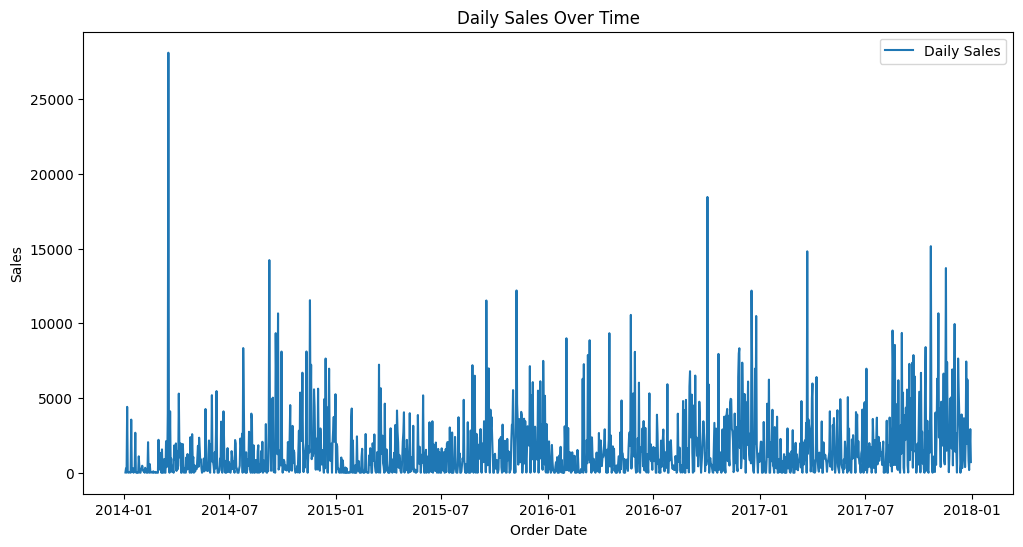

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_aggregated['Order Date'], daily_aggregated['Sales'], label='Daily Sales')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')
plt.legend()
plt.show()

In [11]:
import numpy as np

Q1 = daily_aggregated['Sales'].quantile(0.25)
Q3 = daily_aggregated['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = daily_aggregated[
    (daily_aggregated['Sales'] < lower_bound) | 
    (daily_aggregated['Sales'] > upper_bound)
]

print(f"Number of potential outliers: {len(outliers)}")
outliers.head()


Number of potential outliers: 103


,Order Date,Sales,Quantity,Discount,Profit,Transaction Count,Activity,Order Quarter,Order DayOfWeek,Is Holiday Week
74,2014-03-18,28106.716,48.0,0.434271,-954.7089,11.0,1,1,Tuesday,No
92,2014-04-05,5295.098,54.0,0.003842,253.9044,13.0,1,2,Saturday,No
149,2014-06-01,5188.520,55.0,0.001263,1576.7509,11.0,1,2,Sunday,No
157,2014-06-09,5463.008,66.0,0.134930,629.0289,16.0,1,2,Monday,No
203,2014-07-25,8341.290,22.0,0.000000,384.5084,5.0,1,3,Friday,No


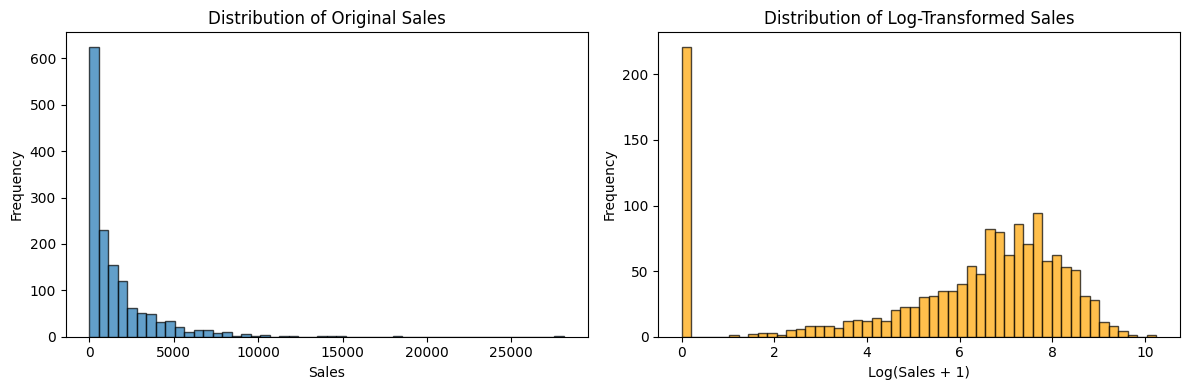

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a new column for the log-transformed sales
daily_aggregated['Log_Sales'] = np.log1p(daily_aggregated['Sales'])
# This uses log(1 + Sales) to handle zero values safely

# Step 2: Compare distributions of original Sales and Log-Transformed Sales
plt.figure(figsize=(12, 4))

# Original Sales distribution
plt.subplot(1, 2, 1)
plt.hist(daily_aggregated['Sales'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Original Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Log-Transformed Sales distribution
plt.subplot(1, 2, 2)
plt.hist(daily_aggregated['Log_Sales'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of Log-Transformed Sales')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [16]:
from statsmodels.tsa.stattools import adfuller

# Suppose 'daily_aggregated' is your DataFrame, and 'Log_Sales' is your log-transformed sales column.
result = adfuller(daily_aggregated['Log_Sales'].dropna())  # dropna() in case of missing values

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}, {value}')

ADF Statistic: -4.833730002029329
p-value: 4.685647313504373e-05
Critical Values 1%, -3.434921564946909
Critical Values 5%, -2.8635590328954197
Critical Values 10%, -2.567844919904611
KPSS Statistic: 4.1970129128366915
p-value: 0.01
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\rites\AppData\Local\Temp\ipykernel_28204\4120287974.py:13: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_result = kpss(daily_aggregated['Log_Sales'].dropna(), regression='c')


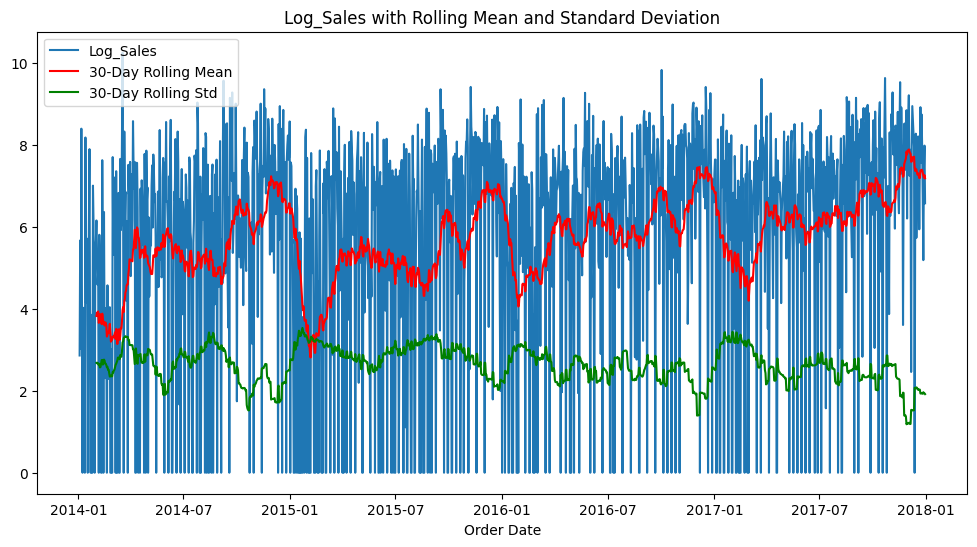

In [18]:
import matplotlib.pyplot as plt

# Set a window size (e.g., 30 days)
window_size = 30
rolling_mean = daily_aggregated['Log_Sales'].rolling(window=window_size).mean()
rolling_std = daily_aggregated['Log_Sales'].rolling(window=window_size).std()

plt.figure(figsize=(12,6))
plt.plot(daily_aggregated['Order Date'], daily_aggregated['Log_Sales'], label='Log_Sales')
plt.plot(daily_aggregated['Order Date'], rolling_mean, color='red', label=f'{window_size}-Day Rolling Mean')
plt.plot(daily_aggregated['Order Date'], rolling_std, color='green', label=f'{window_size}-Day Rolling Std')
plt.xlabel('Order Date')
plt.title('Log_Sales with Rolling Mean and Standard Deviation')
plt.legend()
plt.show()


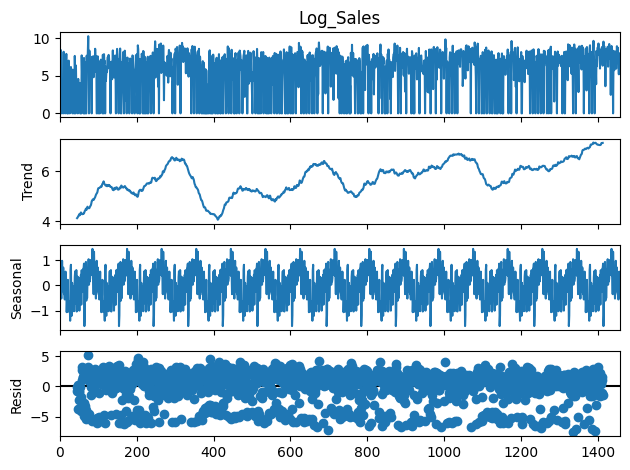

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming a weekly cycle might be relevant (period=7 for daily data)
decomposition = seasonal_decompose(daily_aggregated['Log_Sales'], model='additive', period=90)
decomposition.plot()
plt.show()

In [30]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Rename columns to remove spaces ---
daily_aggregated = daily_aggregated.rename(columns={
    "Order Date": "Order_Date",
    "Sales": "Sales",  # assuming Sales is already fine
    "Log Sales": "Log_Sales",  # if applicable; otherwise, adjust accordingly
    "Transaction Count": "Transaction_Count",
    "Order DayOfWeek": "Order_DayOfWeek",
    "Order Quarter": "Order_Quarter",
    "Is Holiday Week": "Is_Holiday_Week"
})
# If Log_Sales is not already created, create it using log1p transformation
if 'Log_Sales' not in daily_aggregated.columns:
    daily_aggregated['Log_Sales'] = np.log1p(daily_aggregated['Sales'])

# --- Step 2: Create a time trend variable ---
daily_aggregated['Time_Index'] = (daily_aggregated['Order_Date'] - daily_aggregated['Order_Date'].min()).dt.days

# Ensure Activity is numeric (0/1) if not already; if it's categorical, convert it accordingly.
if daily_aggregated['Activity'].dtype.name not in ['int64', 'float64']:
    daily_aggregated['Activity'] = daily_aggregated['Activity'].astype(int)

# --- Step 3: Define and fit the full regression model ---
# We include the following predictors:
# Time_Index, Quantity, Discount, Profit, Transaction_Count, Activity,
# and categorical predictors: Order_Quarter, Order_DayOfWeek, Is_Holiday_Week
formula_all = (
    "Log_Sales ~ Time_Index + Quantity + Discount + Profit + Transaction_Count + Activity "
    "+ C(Order_Quarter) + C(Order_DayOfWeek) + C(Is_Holiday_Week)"
)

model_all = smf.ols(formula=formula_all, data=daily_aggregated).fit()

# Print the model summary to review coefficients, p-values, R-squared, etc.
print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Sales   R-squared:                       0.880
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     660.0
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:12:24   Log-Likelihood:                -2020.0
No. Observations:                1458   AIC:                             4074.
Df Residuals:                    1441   BIC:                             4164.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [33]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Prepare the design matrix by concatenating numeric predictors and dummy variables
predictors = daily_aggregated[['Time_Index', 'Quantity', 'Discount', 'Profit', 'Transaction_Count', 'Activity']].copy()

dummies_quarter = pd.get_dummies(daily_aggregated['Order_Quarter'], prefix='Quarter', drop_first=True)
dummies_day = pd.get_dummies(daily_aggregated['Order_DayOfWeek'], prefix='Day', drop_first=True)
dummies_holiday = pd.get_dummies(daily_aggregated['Is_Holiday_Week'], prefix='Holiday', drop_first=True)

X = pd.concat([predictors, dummies_quarter, dummies_day, dummies_holiday], axis=1)

# Check for missing values
print("Missing values per column:")
print(X.isnull().sum())

# Convert all columns to numeric (float) if they are not already, forcing conversion errors to NaN.
X = X.apply(pd.to_numeric, errors='coerce')

# Fill any NaN values that may have been produced (choose a strategy; here we use 0)
X = X.fillna(0)
# Force all columns in X to be numeric float64 (ensures no 'object' or 'category' dtypes)
X = X.astype(float)

# Now calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


Missing values per column:
Time_Index           0
Quantity             0
Discount             0
Profit               0
Transaction_Count    0
Activity             0
Quarter_2            0
Quarter_3            0
Quarter_4            0
Day_Monday           0
Day_Saturday         0
Day_Sunday           0
Day_Thursday         0
Day_Tuesday          0
Day_Wednesday        0
Holiday_Yes          0
dtype: int64
              Feature        VIF
0          Time_Index   4.184265
1            Quantity  39.838603
2            Discount   2.867645
3              Profit   1.430966
4   Transaction_Count  43.008292
5            Activity   7.953084
6           Quarter_2   1.951792
7           Quarter_3   2.061495
8           Quarter_4   2.372185
9          Day_Monday   1.653039
10       Day_Saturday   1.678213
11         Day_Sunday   1.639586
12       Day_Thursday   1.523150
13        Day_Tuesday   1.612573
14      Day_Wednesday   1.569645
15        Holiday_Yes   1.075622


In [36]:
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Drop multicollinear variables from the formula ---
# We're keeping Transaction_Count and dropping Quantity and Activity
formula_refined = (
    "Log_Sales ~ Time_Index + Discount + Profit + Activity "
    "+ C(Order_Quarter) + C(Order_DayOfWeek) + C(Is_Holiday_Week)"
)

# --- Step 2: Fit the refined model ---
model_refined = smf.ols(formula=formula_refined, data=daily_aggregated).fit()

# --- Step 3: View summary ---
print(model_refined.summary())



                            OLS Regression Results                            
Dep. Variable:              Log_Sales   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.804
Method:                 Least Squares   F-statistic:                     428.6
Date:                Sun, 23 Mar 2025   Prob (F-statistic):               0.00
Time:                        16:22:15   Log-Likelihood:                -2369.3
No. Observations:                1458   AIC:                             4769.
Df Residuals:                    1443   BIC:                             4848.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [37]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Rebuild your X matrix (predictors only) for current model:
predictors = daily_aggregated[['Time_Index', 'Discount', 'Profit', 'Activity']].copy()
dummies_quarter = pd.get_dummies(daily_aggregated['Order_Quarter'], prefix='Quarter', drop_first=True)
dummies_day = pd.get_dummies(daily_aggregated['Order_DayOfWeek'], prefix='Day', drop_first=True)
dummies_holiday = pd.get_dummies(daily_aggregated['Is_Holiday_Week'], prefix='Holiday', drop_first=True)

X = pd.concat([predictors, dummies_quarter, dummies_day, dummies_holiday], axis=1)
X = X.astype(float)

vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


          Feature       VIF
0      Time_Index  3.937459
1        Discount  2.839034
2          Profit  1.360253
3        Activity  7.373655
4       Quarter_2  1.940416
5       Quarter_3  1.995519
6       Quarter_4  2.197972
7      Day_Monday  1.652752
8    Day_Saturday  1.669940
9      Day_Sunday  1.635399
10   Day_Thursday  1.513171
11    Day_Tuesday  1.557674
12  Day_Wednesday  1.442485
13    Holiday_Yes  1.063470


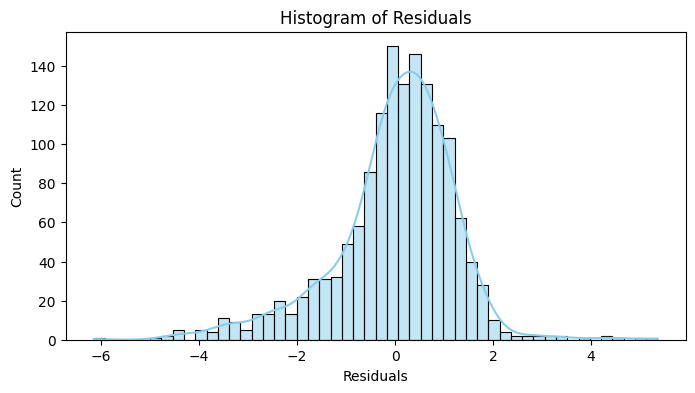

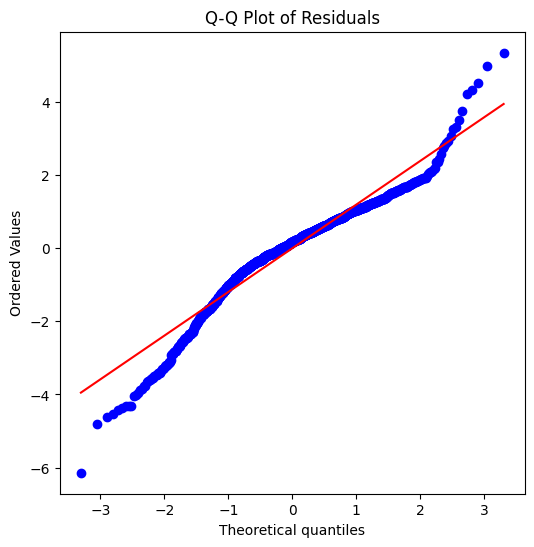

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

residuals = model_refined.resid

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=50, color='skyblue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()


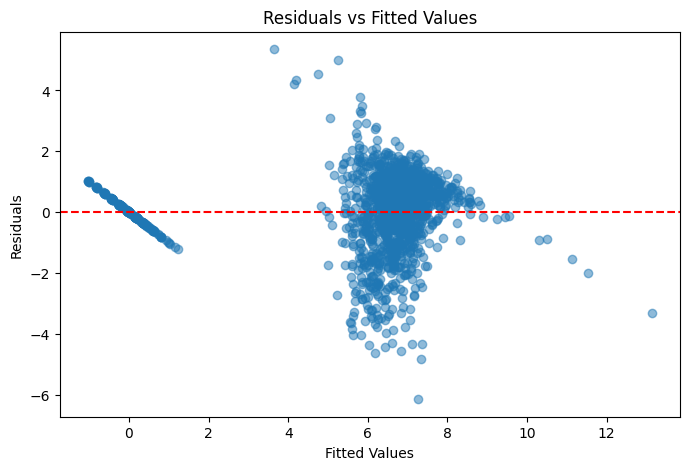

Breusch-Pagan test p-value: 0.0000


In [39]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Residuals vs Fitted Values
plt.figure(figsize=(8, 5))
plt.scatter(model_refined.fittedvalues, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

# Breusch-Pagan test
# Returns: (LM stat, LM p-value, F-stat, F p-value)
from statsmodels.stats.api import het_breuschpagan

bp_test = het_breuschpagan(residuals, model_refined.model.exog)
print(f"Breusch-Pagan test p-value: {bp_test[1]:.4f}")


<Figure size 1000x400 with 0 Axes>

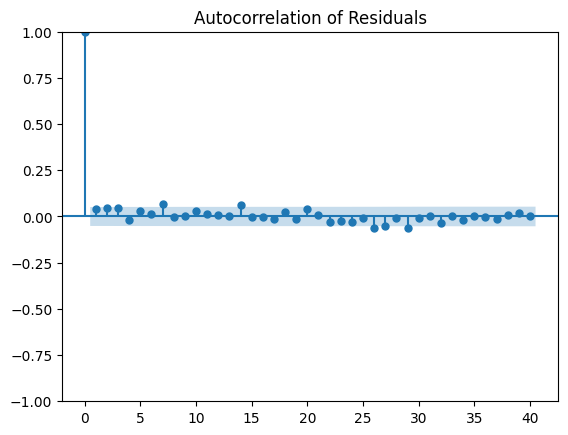

Durbin-Watson statistic: 1.914


In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Autocorrelation plot
plt.figure(figsize=(10, 4))
plot_acf(residuals, lags=40)
plt.title("Autocorrelation of Residuals")
plt.show()

from statsmodels.stats.stattools import durbin_watson

# Calculate Durbin-Watson statistic
dw_stat = durbin_watson(model_refined.resid)
print(f"Durbin-Watson statistic: {dw_stat:.3f}")